In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
koubei = pd.read_csv(
    'data/ijcai2016_koubei_train'
    , header=None, names=['user_id', 'merchant_id', 'location_id', 'timestamp']
#     , dtype=str
#     , parse_dates=[3]
#     , nrows=10
)

In [4]:
pred = pd.read_csv('data/ijcai2016_koubei_test', header=None, names=['user_id', 'location_id'])

In [10]:
merchant = pd.read_csv('data/ijcai2016_merchant_info', header=None, names=['merchant_id', 'budge', 'locations'])

# 从过去数据直接产生推荐

In [5]:
koubei_pred = pd.merge(
    koubei[['user_id', 'location_id', 'merchant_id']].drop_duplicates(),
    pred[['user_id', 'location_id']].drop_duplicates(),
    on=['user_id', 'location_id'], how='inner'
).drop_duplicates()

产生地点和商店的关联

# 根据地理位置和商铺的热点产生推荐

In [69]:
merchant_location = pd.DataFrame(dict(
    heat = koubei.groupby(['merchant_id', 'location_id']).size()
)).reset_index()
merchant_location['heat_rank'] = merchant_location.groupby('location_id').heat.rank(ascending=False, method='first')
mer_loc_rec = merchant_location[merchant_location.heat_rank <= 10]

mer_loc_rec.head()

,merchant_id,location_id,heat,heat_rank
0,1,30,41,8
3,4,257,94,1
4,6,175,112,2
5,7,446,35,10
7,10,446,128,7


In [73]:
koubei_pred = koubei_pred.set_index(['user_id', 'location_id'])
pred = pred.set_index(['user_id', 'location_id'])
remain_pred = pred[~pred.index.isin(koubei_pred.index)].reset_index()

remain_pred.head()

,user_id,location_id
0,753792,112
1,1278336,178
2,1409408,461
3,492160,214
4,1671808,481


In [74]:
remain_loc_pred = pd.merge(
    remain_pred,
    mer_loc_rec[['merchant_id', 'location_id']],
    on='location_id'
)

remain_loc_pred.head()

,user_id,location_id,merchant_id
0,753792,112,571
1,753792,112,820
2,753792,112,2294
3,753792,112,5095
4,753792,112,5231


In [153]:
rmdf = pd.merge(
    remain_loc_pred[['user_id', 'location_id']].drop_duplicates(),
    merchant_location,
    on='location_id', how='left'
)
rmdf.set_index('user_id').to_csv('data/koubei_test_remain')

In [83]:
s = pd.concat(
    [koubei_pred.reset_index(), remain_loc_pred]
).groupby(['user_id', 'location_id']).agg(lambda d: ':'.join([str(i) for i in d]))

In [85]:
s.head()

,,merchant_id
user_id,location_id,
2,132,448:560:1014:1988:2132:2606:4007:4450:6613:6756
5,371,3506:4264:5231:6388:7075:9167
8,362,735:2340:2982:3261:3651:4856:6060:6401:9359:9485
17,11,177:3772:4049:4335:4388:5049:5239:8405:8817:9974
19,6,171:365:820:2606:4264:5231:7249:7834:8335:9485


In [86]:
s.to_csv('submit/0425_locrec.csv')

# 评估预算

获取商铺剩余的预算

In [87]:
all_pred = pd.concat(
    [koubei_pred.reset_index(), remain_loc_pred]
).drop_duplicates()

In [88]:
merchant_budge = pd.DataFrame(dict(
    used=all_pred.groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)
merchant_budge['remain'] = merchant_budge.budge - merchant_budge.used
merchant_budge.head()

,budge,used,remain
merchant_id,,,
1,100,420,-320
2,734,4,730
3,100,6,94
4,100,83,17
6,100,44,56


In [89]:
print(len(merchant_budge) == len(merchant))

True


In [184]:
print('预算超额：%d' % -merchant_budge[merchant_budge.remain<0].remain.sum())
print('总预算：%d' % merchant_budge.budge.sum())
print('比例：%.2f%%' % (len(merchant_budge[merchant_budge.remain<0]) / float(len(merchant_budge)) * 100))
print('口碑转化预算：%d' % koubei_pred.groupby('merchant_id').size().sum())

预算超额：3354508
总预算：1565344
比例：27.43%
口碑转化预算：63171


实际预算和给定预算的比较

In [166]:
koubei = koubei.reset_index()

In [173]:
pred = pred.reset_index()

In [175]:
koubei11 = pd.DataFrame(dict(
    used=koubei[koubei.timestamp.between(20151101,20151130) & koubei.location_id.isin(pred.location_id)].drop_duplicates().groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)

In [176]:
koubei10 = pd.DataFrame(dict(
    used=koubei[koubei.timestamp.between(20151001,20151031) & koubei.location_id.isin(pred.location_id)].drop_duplicates().groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)

In [177]:
koubei09 = pd.DataFrame(dict(
    used=koubei[koubei.timestamp.between(20150901,20150930) & koubei.location_id.isin(pred.location_id)].drop_duplicates().groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)

In [178]:
koubei08 = pd.DataFrame(dict(
    used=koubei[koubei.timestamp.between(20150801,20150831) & koubei.location_id.isin(pred.location_id)].drop_duplicates().groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)

In [179]:
koubei07 = pd.DataFrame(dict(
    used=koubei[koubei.timestamp.between(20150701,20150731) & koubei.location_id.isin(pred.location_id)].drop_duplicates().groupby('merchant_id').size(),
    budge=merchant.set_index('merchant_id').budge
)).fillna(0)

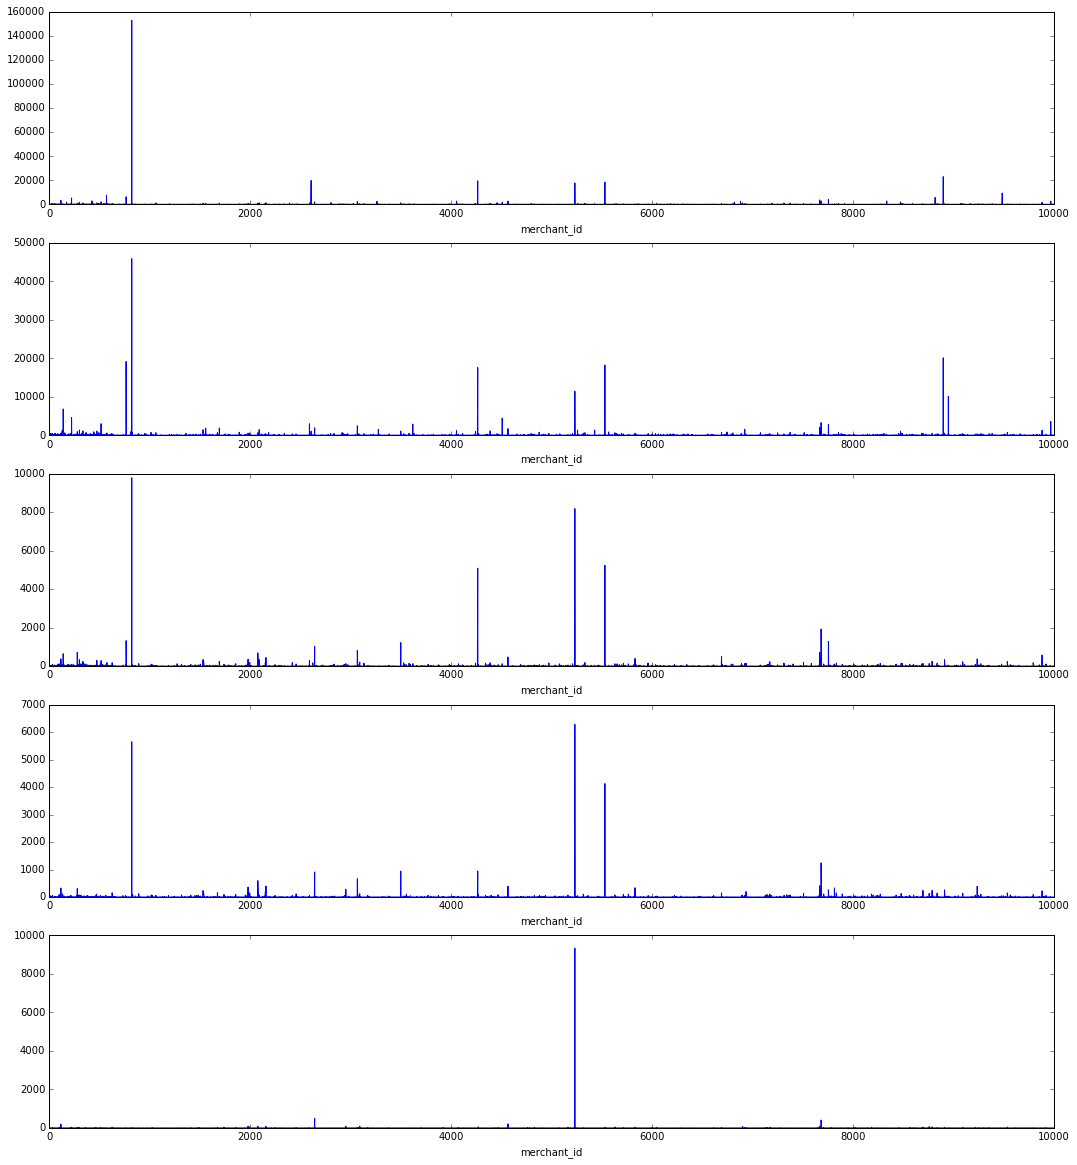

In [180]:
subplot(511); koubei11.used.plot(figsize=(18, 20));
subplot(512); koubei10.used.plot(figsize=(18, 20));
subplot(513); koubei09.used.plot(figsize=(18, 20));
subplot(514); koubei08.used.plot(figsize=(18, 20));
subplot(515); koubei07.used.plot(figsize=(18, 20));

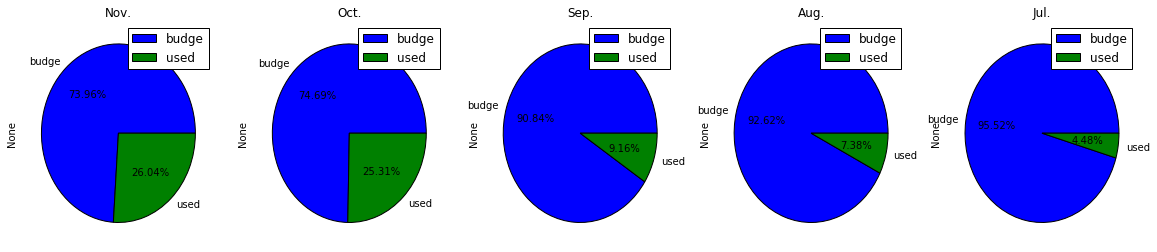

In [181]:
subplot(151); koubei11[koubei11.used>0].sum().plot.pie(figsize=(20, 4), title='Nov.', autopct='%.2f%%', legend=True);
subplot(152); koubei10[koubei10.used>0].sum().plot.pie(figsize=(20, 4), title='Oct.', autopct='%.2f%%', legend=True);
subplot(153); koubei09[koubei09.used>0].sum().plot.pie(figsize=(20, 4), title='Sep.', autopct='%.2f%%', legend=True);
subplot(154); koubei08[koubei08.used>0].sum().plot.pie(figsize=(20, 4), title='Aug.', autopct='%.2f%%', legend=True);
subplot(155); koubei07[koubei07.used>0].sum().plot.pie(figsize=(20, 4), title='Jul.', autopct='%.2f%%', legend=True);

In [182]:
print('Nov.: merchants not used: %d' % (len(koubei11[koubei11.used==0])))
print('Oct.: merchants not used: %d' % (len(koubei10[koubei10.used==0])))
print('Sep.: merchants not used: %d' % (len(koubei09[koubei09.used==0])))
print('Aug.: merchants not used: %d' % (len(koubei08[koubei08.used==0])))
print('Jul.: merchants not used: %d' % (len(koubei07[koubei07.used==0])))

Nov.: merchants not used: 985
Oct.: merchants not used: 2457
Sep.: merchants not used: 3971
Aug.: merchants not used: 4672
Jul.: merchants not used: 5260


In [183]:
print('Nov.: beyond budge: %d' % len(koubei11[koubei11.used>koubei11.budge]))
print('Oct.: beyond budge: %d' % len(koubei10[koubei10.used>koubei10.budge]))
print('Sep.: beyond budge: %d' % len(koubei09[koubei09.used>koubei10.budge]))
print('Aug.: beyond budge: %d' % len(koubei08[koubei08.used>koubei10.budge]))
print('Jul.: beyond budge: %d' % len(koubei07[koubei07.used>koubei10.budge]))

Nov.: beyond budge: 189
Oct.: beyond budge: 287
Sep.: beyond budge: 20
Aug.: beyond budge: 8
Jul.: beyond budge: 1


In [151]:
print('Nov.: ratio of merchants beyond budge: %.2f%%' % (len(koubei11[koubei11.used>koubei11.budge]) / float(len(koubei11[koubei11.used>0])) * 100))

Nov.: ratio of merchants beyond budge: 3.81%


输出前两个月的参考预算

In [188]:
merchant_recent_budge = pd.merge(
    merchant[['merchant_id', 'budge']],
    pd.merge(
        koubei11.reset_index()[['merchant_id', 'used']], koubei10.reset_index()[['merchant_id', 'used']],
        on='merchant_id', suffixes=('_11', '_10')
    ),
    on='merchant_id'
).set_index('merchant_id')
merchant_recent_budge[''] = merchant_recent_budge.apply(lambda g: min(g[0], max(g[1], g[2])), axis=1)
merchant_recent_budge.to_csv('data/merchant_recent_budge.csv')
merchant_recent_budge.head()

,merchant_id,budge,used_11,used_10
0,128,331,309,1266
1,3712,100,1,0
2,1409,100,4,0
3,3201,100,5,9
4,8577,100,28,6


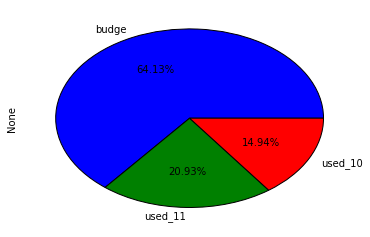

In [191]:
merchant_recent_budge[['budge', 'used_11', 'used_10']].sum().plot.pie(autopct='%.2f%%');

In [193]:
merchant_recent_budge[merchant_recent_budge.merchant_id==1]

,merchant_id,budge,used_11,used_10
2164,1,100,38,1


In [212]:
merchant_recent_budge.set_index('merchant_id').apply(lambda g: min(g[0], max(g[1], g[2])), axis=1)

0        128
1        100
2        100
3        100
4        100
5        100
6       1735
7        100
8        100
9        100
10       154
11       100
12       100
13       100
14       100
15       100
16       445
17       100
18       100
19       100
20       100
21       100
22       132
23       100
24       514
25       100
26       271
27       100
28       100
29       100
        ... 
5880     100
5881     100
5882     100
5883     100
5884     100
5885     100
5886     100
5887     100
5888     100
5889     100
5890     100
5891     100
5892     100
5893     100
5894     100
5895     100
5896     100
5897     100
5898     100
5899     100
5900     100
5901     100
5902     100
5903     100
5904     100
5905     100
5906     100
5907     100
5908     100
5909     100
dtype: float64

In [ ]:
merchant_recent_budge